In [1]:
import numpy as np 
import pandas as pd
from mlp import mlp
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import copy
import datetime

In [148]:
df = pd.read_csv("./dataset/BTC-USD.csv")#[-500:]
print "First:", df.Date.values[0]
print "Last:", df.Date.values[-1]
df.Date = pd.to_datetime(df.Date)
print df.head(), "\n", len(df)
short_term = 50
long_term = 200

First: 2010-07-16
Last: 2018-07-17
        Date     Open     High      Low    Close  Adj Close  Volume
0 2010-07-16  0.04951  0.04951  0.04951  0.04951    0.04951       0
1 2010-07-17  0.04951  0.08585  0.05941  0.08584    0.08584       5
2 2010-07-18  0.08584  0.09307  0.07723  0.08080    0.08080      49
3 2010-07-19  0.08080  0.08181  0.07426  0.07474    0.07474      20
4 2010-07-20  0.07474  0.07921  0.06634  0.07921    0.07921      42 
2917


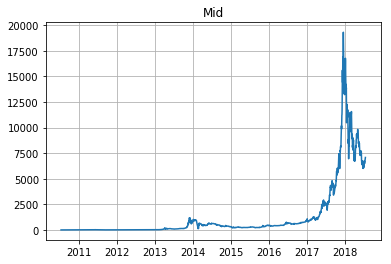

(2917,)


In [149]:
%matplotlib inline
mid = ((df.High + df.Low)/2.)
plt.plot(df.Date, mid)
plt.grid()
plt.title("Mid")
plt.show()
print mid.shape

## Cross analisys

In [150]:
def death_cross(a, b, long_days=30, short_days=0, xlabels=None):
    m = a.shape[0]
    a_n = []
    b_n = []
    x_n = []
    for i in xrange(long_days, m):
        a_n.append(a[(i-long_days):i].mean()) 
        b_n.append(b[(i-short_days):i].mean())
        if xlabels is not None:
            x_n.append(xlabels[i-1])
            
    if xlabels is not None:
         return np.hstack((x_n)),np.hstack((a_n)), np.hstack((b_n))
    else:
        return np.hstack((a_n)), np.hstack((b_n))

def tscore(y_real, y_pred):
    
    pred_diff = y_pred[1:] - y_pred[:-1]
    real_diff = y_real[1:] - y_real[:-1]
    
    real_bin = np.where(1, real_diff>0, 0)
    pred_bin = np.where(1, pred_diff>0, 0)

    bn =  (y_real.shape[0] - np.count_nonzero(pred_bin - real_bin, axis=0))/float(y_real.shape[0])
    return bn

In [151]:
xlabels, longterm, shortterm = death_cross(mid.values, mid.values,
                                           long_days=long_term, short_days=short_term, xlabels=df.Date.values)

In [152]:
def long_cross(long_term, short_term, xlabels=None):
    lo = long_term.shape[0]
    crosses = []
    labels = []
    greater = True
    prev_greater = True
    for i in xrange(lo):
        if long_term[i] >= short_term[i]:
            greater = True
        else:
            greater = False
            
        if (greater == prev_greater):
            crosses.append(long_term[i])
            labels.append(xlabels[i])
            prev_greater = not(greater)
            
    if xlabels is None:
        return np.hstack((crosses))
    else: 
        return np.hstack((labels)), np.hstack((crosses))
    
lcrosses, crosses = long_cross(longterm, shortterm, xlabels)

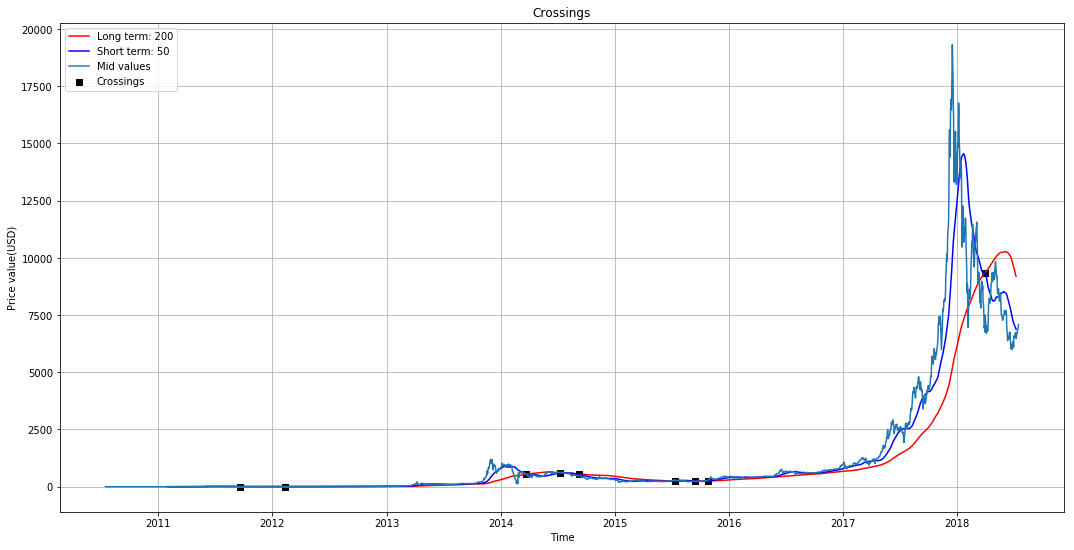

In [153]:
%matplotlib inline

plt.figure(figsize = (18,9))
plt.plot(xlabels, longterm, c="r", label="Long term: %s"%long_term)
plt.plot(xlabels, shortterm, c="b", label="Short term: %s"%short_term)
plt.plot(df.Date, mid, label="Mid values")

plt.scatter(lcrosses, crosses, c="k",marker="s", label="Crossings")


plt.grid()
plt.legend(loc="best")
plt.title("Crossings")
plt.xlabel("Time")
plt.ylabel("Price value(USD)")
plt.show()

## Do highs move faster than lows?

In [154]:
p = tscore(df.Low.values, df.High.values)
print ">>In %.2f%% of the cases, the high follows the low (and vice versa), but in %.2f%% it surprisingly does not happen."%(p*100, (1-p)*100)
print "Temporaly speaking"

>>In 68.46% of the cases, the high follows the low (and vice versa), but in 31.54% it surprisingly does not happen.
Temporaly speaking


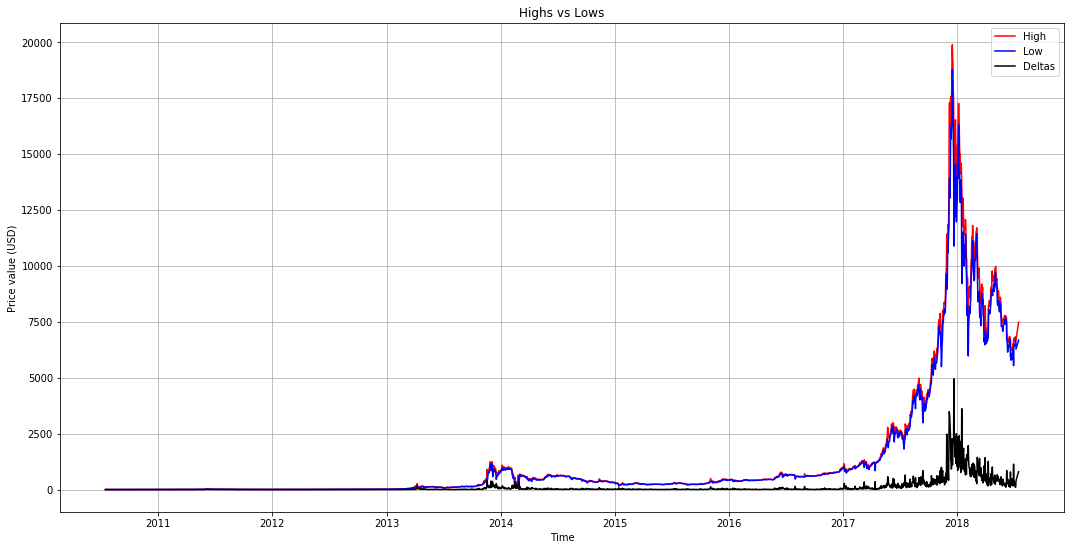

In [155]:
deltas = df.High.values-df.Low.values

plt.figure(figsize = (18,9))
plt.plot(df.Date.values, df.High.values, c="r", label="High")
plt.plot(df.Date.values, df.Low.values, c="b", label="Low")
plt.plot(df.Date.values, deltas, c="k", label="Deltas")


plt.grid()
plt.legend(loc="best")
plt.title("Highs vs Lows")
plt.xlabel("Time")
plt.ylabel("Price value (USD)")
plt.show()


## Looking at the Pearson coefficient (linear)

In [156]:
np.corrcoef(deltas, mid.values)

array([[1.        , 0.83526752],
       [0.83526752, 1.        ]])

## Open vs close values

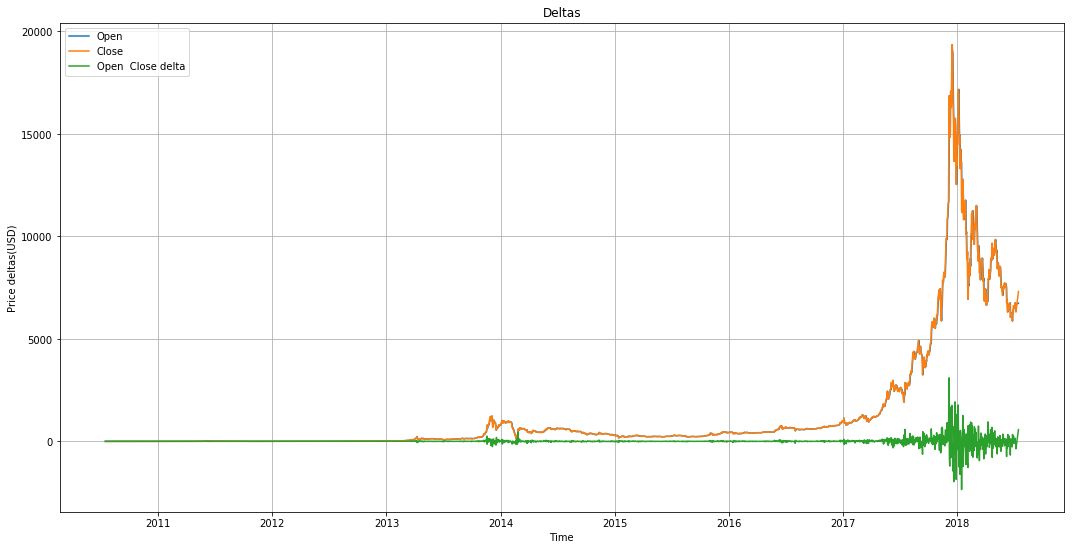

In [157]:
open_close_delta = df.Close - df.Open
plt.figure(figsize = (18,9))
plt.plot(df.Date, df.Open, label="Open")
plt.plot(df.Date, df.Close, label="Close")
plt.plot(df.Date, open_close_delta, label="Open  Close delta")

plt.grid()
plt.legend(loc="best")
plt.title("Deltas")
plt.xlabel("Time")
plt.ylabel("Price deltas(USD)")
plt.show()